# Simulation counterbalancing vs. regression
This notebook evaluates the effectiveness of counterbalancing and confound regression in removing the influence of a known confound on machine learning analyses of (simulations of) mutivoxel pattern data.

In [2]:
# General packages
import numpy as np
import seaborn as sns
import pandas as pd

# Bunch of scikit-learn stuff
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import f_classif

# Specific statistics-functions
from scipy.stats import pearsonr

# Misc.
from tqdm import tqdm_notebook
from copy import deepcopy
from matplotlib_venn import venn3

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Custom code! (install skbold by `pip install skbold`; counterbalance.py is in cwd)
from skbold.preproc import ConfoundRegressor
from counterbalance import CounterbalancedStratifiedSplit

### A note on how we simulate data
In this notebook's simulations, we are going to simulate three variables, with $N$ denoting the number of samples, and $K$ denoting the number of features:

- **y**: an $N\times 1$ vector with values {0, 1}
- **c**: an $N\times 1$ vector with values {0, 1} if continuous, else $c \sim \mathcal{N}(0,\,1)$
- **X**: an $N\times K$ matrix, in each each column $j$ is generated as $X_{j} = \beta_{1} c + \beta_{2} y + \epsilon,\ \epsilon \sim \mathcal{N}(0, 1)$

By tweaking the parameters $\beta c$ and $\beta y$, we can specifically "tune" how much variance of $y$ is explained by the "true" (i.e., unconfounded) signal (which we call $signal\ R^2$) and how much variance of $y$ is explained by the "confounded signal" (i.e., signal in $X$ which is confounded by $c$; we call this $confound\ R^2$). 

Basically, in our data-generator (function is defined below) we generate data ($X$, $y$, and $c$) with a specified correlation between $y$ and $c$, $\rho(cy)$, and subsequently calculate the $confound\ R^2$ and $signal\ R^2$ terms. We then check whether these terms correspond to the desired values for these terms; if not, we adjust the generative parameters ($\beta_{1}$ and $\beta_{2}$) slightly and try the entire process again until we get the terms that we want.

Below, we visualized the $confound\ R^2$ and $signal\ R^2$ terms in a Venn-diagram. On the right of the diagram, we describe the steps to get these terms.

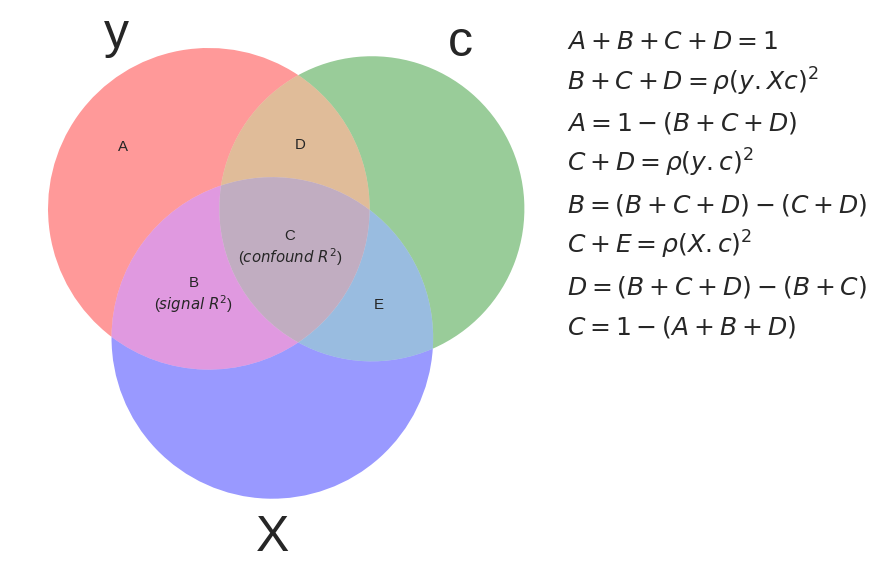

In [3]:
mappings = {'100': 'A', '110': 'D', '010': '',
            '101': "B\n($signal\ R^2$)", '111': 'C\n($confound\ R^2$)', '011': 'E',
            '001': ''}

plt.figure(figsize=(10, 10))
v = venn3(subsets=(1, 1, 0.1, 1, 0.3, 0.1, 0.6), set_labels=('y', 'c', 'X'))

for key, value in mappings.items():
    v.get_label_by_id(key).set_text(value)
    v.get_label_by_id(key).set_size(15)
    
for label in ['A', 'B', 'C']:
    v.get_label_by_id(label).set_size(50)
    
plt.text(0.7, 0.5, "$A+B+C+D = 1$", fontsize=25)
plt.text(0.7, 0.4, r"$B+C+D = \rho(y.Xc)^2$", fontsize=25)
plt.text(0.7, 0.3, "$A = 1 - (B+C+D)$", fontsize=25)
plt.text(0.7, 0.2, r"$C+D = \rho(y.c)^2$", fontsize=25)
plt.text(0.7, 0.1, "$B = (B+C+D) - (C+D)$", fontsize=25)
plt.text(0.7, 0.0, r"$C+E = \rho(X.c)^2$", fontsize=25)
plt.text(0.7, -.1, "$D = (B+C+D) - (B+C)$", fontsize=25)
plt.text(0.7, -.2, "$C = 1 - (A+B+D)$", fontsize=25)
plt.show()

## Define some functions
Below, we define our main data-generation function - `generate_data` - which generates three variables - $X$, $y$, $c$ - corresponding to our predictors, target, and confound, respectively. (But when setting `c=None`, you can also only simulate $X$ and $y$ *without* $c$.)

In [46]:
def get_r2(iv, dv, stack_intercept=True):
    """ Regress dv onto iv and return r-squared.
    
    Parameters
    ----------
    iv : numpy array
        Array of shape N (samples) x K (features)
    dv : numpy array
        Array of shape N (samples) x 1
    stack_intercept : bool
        Whether to stack an intercept (vector with ones of length N).
    
    Returns
    -------
    r2 : float
        R-squared model fit.
    """
    
    if iv.ndim == 1:
        # Add axis if shape is (N,)
        iv = iv[:, np.newaxis]
    
    if stack_intercept:
        iv = np.hstack((np.ones((iv.shape[0], 1)), iv))
    
    beta = np.linalg.lstsq(iv, dv)[0]
    dv_hat = iv.dot(beta).squeeze()
    r2 = pearsonr(dv_hat, dv)[0] ** 2
    if np.isnan(r2):
        r2 = 0
    
    return r2



def generate_data(n_samp, k_feat, c_type, corr_cy, signal_r2, confound_r2=None, verbose=False):
    """ Generate data with known (partial) R2 "structure".
    
    Parameters
    ----------
    n_samp : int
        Number of samples (N) in the data (X, y, and c)
    k_feat : int
        Number of features (K) in the data (X)
    c_type : str
        Either "continuous" or "categorical". If categorical,
        the data a balanced vector with ones and zeros
    corr_cy : float
        Number between -1 and 1, specifying the correlation
        between the confound (c) and the target (y)
    signal_r2 : float
        Number between 0 and 1, specifying the explained variance
        of y using X, independent of the confound contained in X;
        (technically, the semipartial correlation rho(xy.c)
    confound_r2 : float or None
        Number between 0 and 1 (or None), specifying the shared variance 
        explained of y of x and c (i.e. the explained variance 
        of the confound-related information in x). If None,
        no confound R2 will be left unspecified (which can be used
        to specify a baseline).
    verbose : bool
        Whether to print (extra) relevant information
    
    Returns
    -------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values,
        depending on what you set for the `c_type` argument.
    """
    
    if n_samp % 2 != 0:
        raise ValueError("Please select an even number of samples "
                         "(Makes things easier.)")

    if confound_r2 is not None:
        if np.abs(corr_cy) < np.sqrt(confound_r2):
            raise ValueError("The desired corr_cy value is less than the square "
                             "root of the desired confound R-squared ... This is "
                             "impossible to generate.")
        
    # Generate y (balanced, 50% class 0, 50% class 1)
    y = np.repeat([0, 1], repeats=n_samp / 2)
    
    # Generate c (confound), with given correlation corr_cy
    if c_type == 'categorical':
        # Simply shift ("roll") y to create correlation using the "formula":
        # to-shift = N / 4 * (1 - corr_cy)
        to_roll = int((n_samp / 4) * (1 - corr_cy))
        c = np.roll(y, to_roll)
    elif c_type == 'continuous':
        # If c is continuous, just sample y + random noise
        noise_factor = 100
        c = y + np.random.randn(n_samp) * noise_factor
        corr = pearsonr(c, y)[0]
        
        while np.abs(corr - corr_cy) > 0.01:
            # Decrease noise if the difference is too big
            noise_factor -= 0.01
            c = y + np.random.randn(n_samp) * noise_factor
            corr = pearsonr(c, y)[0]        
    else:
        raise ValueError("For c_type, please select from {'continuous', "
                         "'categorical'}")
    
    # Define X as a matrix of N-samples by K-features
    X = np.zeros((n_samp, k_feat))
    
    # Pre-allocate arrays for average signal_r2 values and confound_r2 values
    signal_r2_values = np.zeros(k_feat)
    confound_r2_values = np.zeros(k_feat)
    
    icept = np.ones((n_samp, 1))
    
    iterator = tqdm_notebook(np.arange(k_feat)) if verbose else np.arange(k_feat)
    for i in iterator:
        
        # Define generative parameters (gen_beta_y = beta-parameter for y in model of X)
        # Upon advice of Steven S., 'reset' generative parameters after each generation
        gen_beta_y = 1
        gen_beta_c = 1
        noise_factor = 1
        
        while True:
            
            should_continue = False
            
            # Generate X as a linear combination of y, c, and random noise
            this_c = 0 if confound_r2 is None else c
            this_X = (gen_beta_y * y + gen_beta_c * this_c + np.random.randn(n_samp) * noise_factor)
            this_X = this_X[:, np.newaxis]
            
            # Fit y = b1X
            y_x_r2 = get_r2(iv=this_X, dv=y, stack_intercept=True)  # B + C
            
            # Increase/decrease noise if difference observed r(yx)**2 is too big/small,
            # because if y_x_r2 < (signal_r2 + confound_r2), you won't find proper data anyway
            tmp_confound_r2 = 0 if confound_r2 is None else confound_r2
            difference_obs_vs_desired = y_x_r2 - (signal_r2 + tmp_confound_r2)
            if np.abs(difference_obs_vs_desired) > 0.01:
                # If correlation too small/big, adjust noise factor and CONTINUE
                if difference_obs_vs_desired < 0:
                    noise_factor -= 0.01
                else:
                    noise_factor += 0.01
                continue
            
            if confound_r2 is None:
                # We don't care about confound_r2
                unique_var_x = y_x_r2
            else:
                # Fit y = b1X + b2C
                y_xc_r2 = get_r2(iv=np.hstack((this_X, c[:, np.newaxis])), dv=y,
                             stack_intercept=True)  # B + C + D
                resid_y = 1 - y_xc_r2  # A = 1 - (B + C + D)

                # Fit y = b1C
                y_c_r2 = get_r2(iv=c, dv=y, stack_intercept=True)  # C + D
                unique_var_x = y_xc_r2 - y_c_r2  # B
            
            # Increase/decrease generative param for y if difference 
            # r(yx.c) is too small/big ...
            difference_obs_vs_desired = unique_var_x - signal_r2
            if np.abs(difference_obs_vs_desired) > 0.01:
                if difference_obs_vs_desired < 0:
                    gen_beta_y += 0.01
                else:
                    gen_beta_y -= 0.01
                
                if confound_r2 is None:
                    continue
                else:
                    should_continue = True
            else:
                if confound_r2 is None:
                    break
                    
            unique_var_c = y_xc_r2 - y_x_r2  # D
            shared_var_xc = 1 - resid_y - unique_var_x - unique_var_c  # C

            # Also check if shared variance of c and x (component C) is appropriate;
            # if not, adjust generative parameter and CONTINUE
            difference_obs_vs_desired = shared_var_xc - confound_r2
            if np.abs(difference_obs_vs_desired) > 0.01:
                if difference_obs_vs_desired < 0:
                    gen_beta_c += 0.01
                else:
                    gen_beta_c -= 0.01
                should_continue = True
            
            if should_continue:
                continue
            else:
                break

        # If we didn't encounter a "break" statement, we must have found
        # data with the correct specifications ...
        X[:, i] = this_X.squeeze()
        signal_r2_values[i] = unique_var_x
        if confound_r2 is not None:
            confound_r2_values[i] = shared_var_xc
        
    if verbose:
        print("Signal r2: %.3f" % signal_r2_values.mean())
        
        if confound_r2 is not None:
            print("Confound r2: %.3f" % confound_r2_values.mean())
        
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(np.corrcoef(X.T), aspect='auto', cmap='RdBu')
        plt.title("Correlations between features")
        plt.colorbar()
        plt.grid('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Signal R2 values")
        plt.hist(signal_r2_values, bins='auto')
        
        plt.subplot(1, 3, 3)
        plt.title("Confound R2 values")
        plt.hist(confound_r2_values, bins='auto')
        plt.tight_layout()
        plt.show()
    
    if confound_r2 is None:
        return X, y
    else:
        return X, y, c


Signal r2: 0.097
Confound r2: 0.152


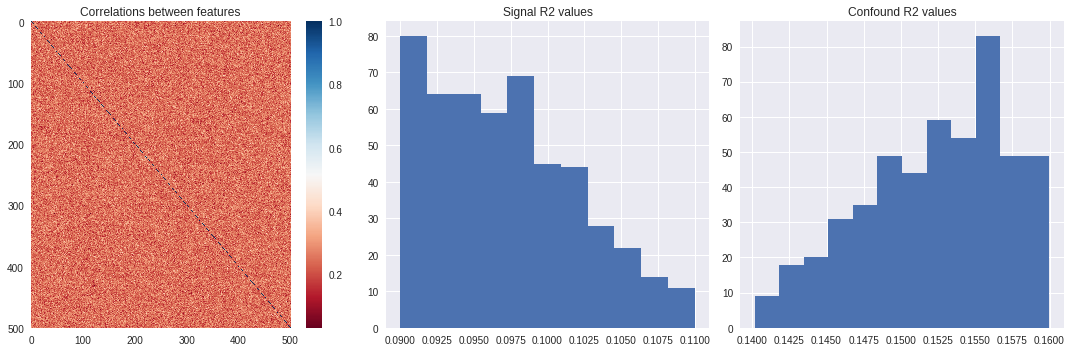

In [48]:
# Testing!
data_args = dict(n_samp=240, k_feat=500, c_type='categorical', corr_cy=0.65,
                 signal_r2=0.1, confound_r2=0.15, verbose=True)
X, y, c = generate_data(**data_args)

Below, we define several functions to quickly run classification analyses using different confound-strategies we're evaluating in this notebook:

- **none**: just run a classification analysis (predict $y$ from $X$) without treating the confound ($c$)
- **regress**: first regress out $c$ from $X$, then run a classification analysis (predict $y$ from $X$)
- **cb** (counterbalance): first subsample $X$ and $y$ until $\rho(yc) \approx 0$, then run a classification analysis (predict $y$ from $X$; also, it's made sure that $\rho(yc) = 0$ also in *each fold*!)

In [49]:
def run_without_confound_control(X, y, c, pipeline, n_splits, arg_dict):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
        
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['none'] * n_splits
    
    skf = StratifiedKFold(n_splits=n_splits)
    scores = np.zeros(n_splits)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        pipeline.fit(X_train, y_train)
        scores[i] = pipeline.score(X_test, y_test)
        
    results['score'] = scores
    
    return results


def run_with_confound_regression(X, y, c, pipeline, n_splits, arg_dict):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : nu1mpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)

    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
 
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['regress'] * n_splits

    skf = StratifiedKFold(n_splits=n_splits)
    scores = np.zeros(n_splits)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        
        cr = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
        this_pipe = deepcopy(pipeline).steps
        this_pipe.insert(0, ('regress', cr))
        this_pipe = Pipeline(this_pipe)
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        this_pipe.fit(X_train, y_train)
        scores[i] = this_pipe.score(X_test, y_test)
        
    results['score'] = scores
    
    return results

def run_with_counterbalancing(X, y, c, pipeline, n_splits, arg_dict, 
                              c_type='categorical', metric='corr', threshold=0.01, verbose=False):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
    
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """

    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['cb'] * n_splits

    results_corr = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(arg_dict['k_feat']*2)])
    results_corr['ki'] = np.tile(np.arange(arg_dict['k_feat']), reps=2)
    results_corr['before_after'] = ['before'] * arg_dict['k_feat'] + ['after'] * arg_dict['k_feat']
    
    corrs_xc_before = [pearsonr(c, X[:, i])[0] for i in range(X.shape[1])]
    corrs_xy_before = [pearsonr(y, X[:, i])[0] for i in range(X.shape[1])]
    
    skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=n_splits, c_type=c_type, verbose=verbose)
    try:
        skf.check_counterbalance_and_subsample()
    except ValueError as ve:
        results['score'] = np.zeros(n_splits)
        corrs_xc_after = np.zeros_like(corrs_xc_before)
        corrs_xy_after = np.zeros_like(corrs_xy_before)
        results_corr['cx'] = np.concatenate((corrs_xc_before, corrs_xc_after))
        results_corr['xy'] = np.concatenate((corrs_xy_before, corrs_xy_after))
        return results, results_corr

    X, y, c = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    
    corrs_xc_after = np.array([pearsonr(c, X[:, i])[0] for i in range(X.shape[1])])
    corrs_xy_after = np.array([pearsonr(y, X[:, i])[0] for i in range(X.shape[1])])
    results_corr['cx'] = np.concatenate((corrs_xc_before, corrs_xc_after))
    results_corr['xy'] = np.concatenate((corrs_xy_before, corrs_xy_after))
    
    scores = np.zeros(n_splits)

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train, c_train = X[train_idx], y[train_idx], c[train_idx]
        X_test, y_test, c_test = X[test_idx], y[test_idx], c[test_idx]
        pipeline.fit(np.hstack((X_train, c_train[:, np.newaxis])), y_train)
        scores[i] = pipeline.score(np.hstack((X_test, c_test[:, np.newaxis])), y_test)
    
    results['score'] = scores
    
    return results, results_corr

### Fixed parameters / settings


In [50]:
pipeline = Pipeline([

    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

n_splits = 10  # i.e. 10-fold cross-validation

## Scenario 1: what happens when we vary *confound $R^2$* and *$\rho(cy)$*?
... or, in other words, what happens when we increase the amount of confounded "signal" in X (area *C* in the venn-diagram) and the initial correlation between the confound (c) and the target (y)?

We evaluate the following values for the parameter $\rho(cy)$:
- $\rho(cy) \in \{0.25, 0.3, 0.35..., 0.85\}$

We set the range of values (in steps of 0.05) for $confound\ R^2$ dynamically, because the maximum value for $confound\ R^2$ depends on the $\rho(cy)$ parameter. For example, we cannot set $confound\ R^2 = 0.5$ when $\rho(cy) = 0.6$, because $\sqrt{0.5} > 0.6$. Thus:

- $confound\ R^2 \in \{0.00, 0.05, ..., \rho(cy)^2 - (\rho(cy)^2\ mod\ 0.05)\}$

And we'll use the following fixed parameters:
- $N = 240$
- $K = 5$
- $signal\ R^2=0.1$

Importantly, we also track the correlations $\rho(xy)$ and $\rho(xc)$ before and after counterbalancing, because there is something weird going on (as we'll explain later).

### Confound = categorical
Here, the confound is categorical with values {0, 1}

In [75]:
# We do it three times for robustness
simulations = 20

# Specify arguments for data generations (we'll set corr_cy and confound_r2 later)
data_args = dict(n_samp=240, k_feat=5, c_type='categorical', corr_cy=None,
                 signal_r2=0.1, confound_r2=None, verbose=False)

# The values for corr_cy to loop over
corr_cy_vec = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

# The confound_r2 values to loop over
confound_r2_vecs = [np.arange(0, corr_cy ** 2, 0.05)
                    for corr_cy in corr_cy_vec]

# The 'baseline scores' to keep track of (scores on data generated without
# any influence of the confound)
baseline_scores = np.zeros((simulations, len(corr_cy_vec)))

results_sce1 = []
results_corr_sce1 = []

# Loop over simulations
for sim in np.arange(simulations):

    print("Simulation: %i" % (sim + 1))
    
    # Loop over values for corr_cy
    for i, corr_cy in enumerate(corr_cy_vec):
        data_args.update(corr_cy=corr_cy)
        data_args.update(confound_r2=None)
        Xbase, ybase = generate_data(**data_args) 
        baseline_scores[sim, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()

        confound_r2_vec = confound_r2_vecs[i]
        print("corr_cy: %.3f, confound_r2: %r" % (corr_cy, np.around(confound_r2_vec, 3).tolist()))
        
        # Loop over values for confound_r2
        for ii, confound_r2 in enumerate(confound_r2_vec):
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results_sce1.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results_sce1.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))    
            res, corrs = run_with_counterbalancing(X, y, c, pipeline, n_splits, c_type='categorical',
                                                   arg_dict=data_args)
            results_corr_sce1.append(corrs)
            results_sce1.append(res)

Simulation: 1
corr_cy: 0.250, confound_r2: [0.0, 0.05]
corr_cy: 0.300, confound_r2: [0.0, 0.05]
corr_cy: 0.350, confound_r2: [0.0, 0.05, 0.1]
corr_cy: 0.400, confound_r2: [0.0, 0.05, 0.1, 0.15]
corr_cy: 0.450, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.500, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.550, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
corr_cy: 0.600, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
corr_cy: 0.650, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
corr_cy: 0.700, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
corr_cy: 0.750, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
corr_cy: 0.800, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
corr_cy: 0.850, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
Simulation: 2
corr_cy: 0.250, confound_r2: [0.0, 0.05]
corr_cy: 0.300, confou

corr_cy: 0.850, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
Simulation: 10
corr_cy: 0.250, confound_r2: [0.0, 0.05]
corr_cy: 0.300, confound_r2: [0.0, 0.05]
corr_cy: 0.350, confound_r2: [0.0, 0.05, 0.1]
corr_cy: 0.400, confound_r2: [0.0, 0.05, 0.1, 0.15]
corr_cy: 0.450, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.500, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.550, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
corr_cy: 0.600, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
corr_cy: 0.650, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
corr_cy: 0.700, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
corr_cy: 0.750, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
corr_cy: 0.800, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
corr_cy: 0.850, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.

corr_cy: 0.800, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
corr_cy: 0.850, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
Simulation: 19
corr_cy: 0.250, confound_r2: [0.0, 0.05]
corr_cy: 0.300, confound_r2: [0.0, 0.05]
corr_cy: 0.350, confound_r2: [0.0, 0.05, 0.1]
corr_cy: 0.400, confound_r2: [0.0, 0.05, 0.1, 0.15]
corr_cy: 0.450, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.500, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2]
corr_cy: 0.550, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
corr_cy: 0.600, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
corr_cy: 0.650, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
corr_cy: 0.700, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
corr_cy: 0.750, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
corr_cy: 0.800, confound_r2: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.

Let's plot it! The plot consists of subplots organized in three columns and six rows. Each *row* contains the results from a different $\rho(cy)$ setting. The first row shows results from data with $\rho(cy) = 0.4$, the second from data with $\rho(cy) = 0.5$, etc. 

In the first column, the mean accuracy across folds is plotted for a range of $confound\ R^2$ values. Note that the *specific* range of $confound\ R^2$ values depends on the $\rho(cy)$ value, viz,. you cannot generate data with $confound\ R^2 > \rho(cy)^2$. These mean accuracies across $confound\ R^2$ values is plotted for the three methods ('none', 'cb', and 'regress') as well as a (dashed orange) line indicating the performance if there would be no $confound\ R^2$, only $signal\ R^2$.

The second and third rows provide some extra information about what is happening in the counterbalance method. 
The second column shows $\rho(xc)$, i.e. the mean correlation between our features (from X) and the confound (c), both **before** subsampling (blue) and **after** subsampling (green). The third column shows $\rho(xy)$, i.e. the mean correlation between our features (from X) and the target (y), again both **before** and **after** subsampling.

Note that if the counterbalancing yields too few samples (i.e. has to undersample so much that it doesn't leave any samples), then score is set to 0 (also for the correlations $\rho(cx)$ and $\rho(xy)$).

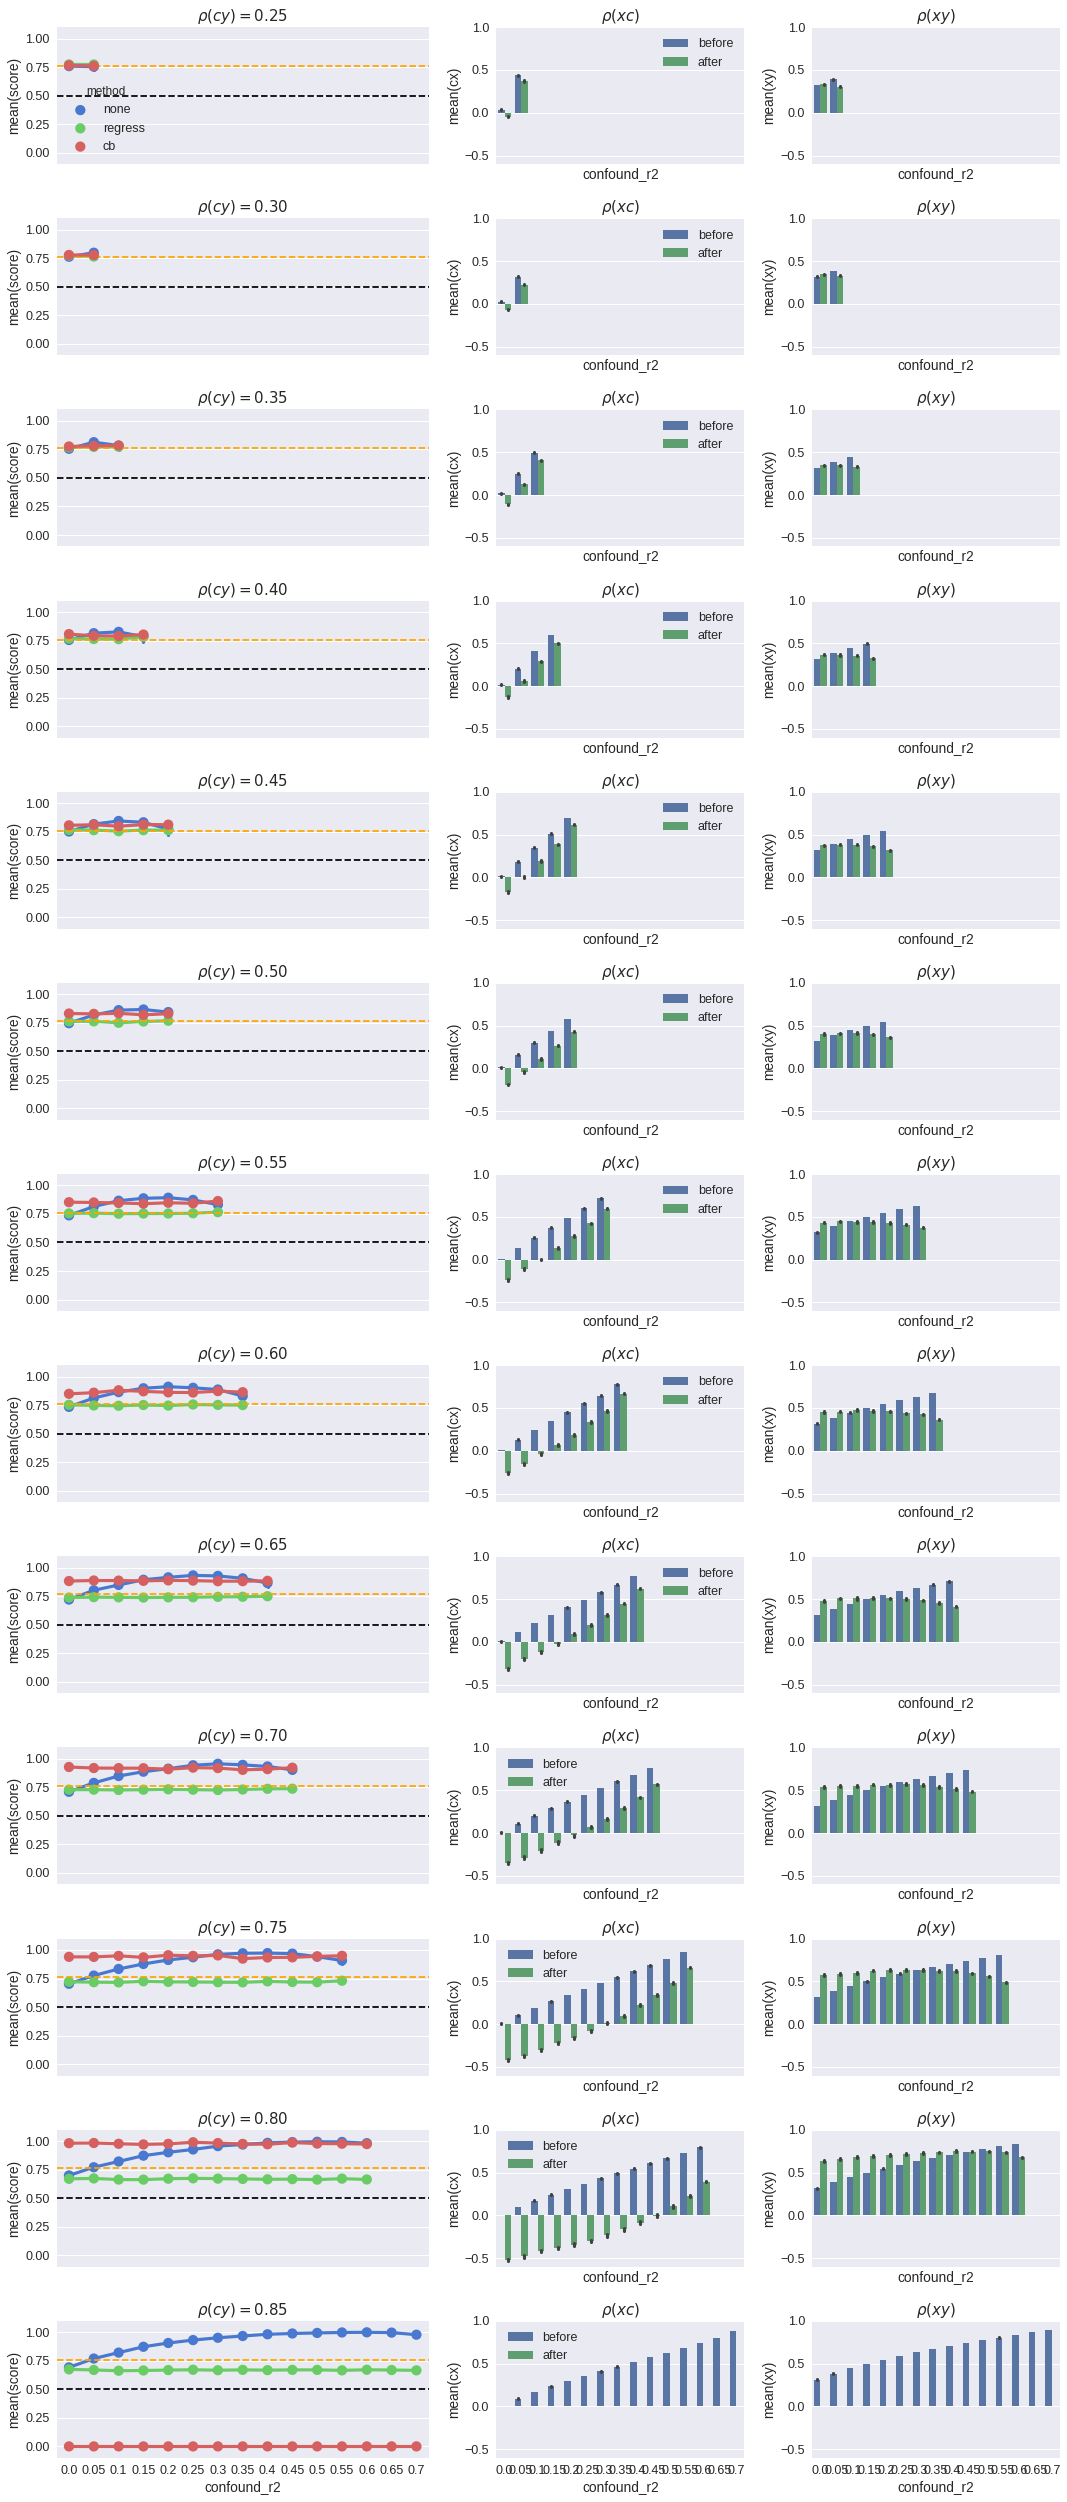

In [77]:
sns.set(font_scale=1.25)
df_sce1 = pd.concat(results_sce1)
df_corrs_sce1 = pd.concat(results_corr_sce1)
fig, axes = plt.subplots(len(corr_cy_vec), 3, figsize=(15, 35), gridspec_kw={'width_ratios': [1.5, 1, 1]},
                         sharex=True, sharey=False)

for i in range(len(axes)):
    tmp = df_sce1[df_sce1.corr_cy == corr_cy_vec[i]]
    axes[i][0].set_title(r"$\rho(cy) = %.2f$" % corr_cy_vec[i])
    g = sns.pointplot(x='confound_r2', y='score', hue='method',
                   data=tmp, size=5, aspect=2,
                   palette="muted", ax=axes[i][0])
    
    if i != 0:
        g.legend_.remove()
    
    if i != len(axes) - 1:
        axes[i][0].set_xlabel('')
    
    g.set_ylim((-0.1, 1.1))
    axes[i][0].axhline(y=0.5, c='black', ls='--')
    axes[i][0].axhline(y=baseline_scores[:, i].mean(), c='orange', ls='--')

    tmp = df_corrs_sce1[df_corrs_sce1.corr_cy == corr_cy_vec[i]]
    axes[i][1].set_title(r'$\rho(xc)$')
    g = sns.barplot(x="confound_r2", y="cx", hue="before_after", data=tmp, ax=axes[i][1])
    g.legend_.remove()
    axes[i][1].legend(loc='best')
    axes[i][2].set_title(r'$\rho(xy)$')
    g.set_ylim((-0.6, 1))
    g = sns.barplot(x="confound_r2", y="xy", hue="before_after", data=tmp, ax=axes[i][2])
    g.legend_.remove()
    g.set_ylim((-0.6, 1))
    
fig.tight_layout()

As you can see, the blue line (confound not controlled for) increases when $confound\ R^2$ increases, as you would expect. You also see that confound regression (green line) nicely follows the orange dashed line, which indicates the scanario in which confound plays no role. 

Lastly, we an interesting (disturbing?) thing happening with the counterbalancing method: when $\rho(cy)$ increases, the counterbalancing method starts to show positive bias, i.e., scores higher than you should see when the confound is adequately dealt with. The third column of graphs shows the reason: subsampling seems to increase the correlation between the features (X) and y (i.e. $signal\ R^2$ seems to increase)!

This is shown below:

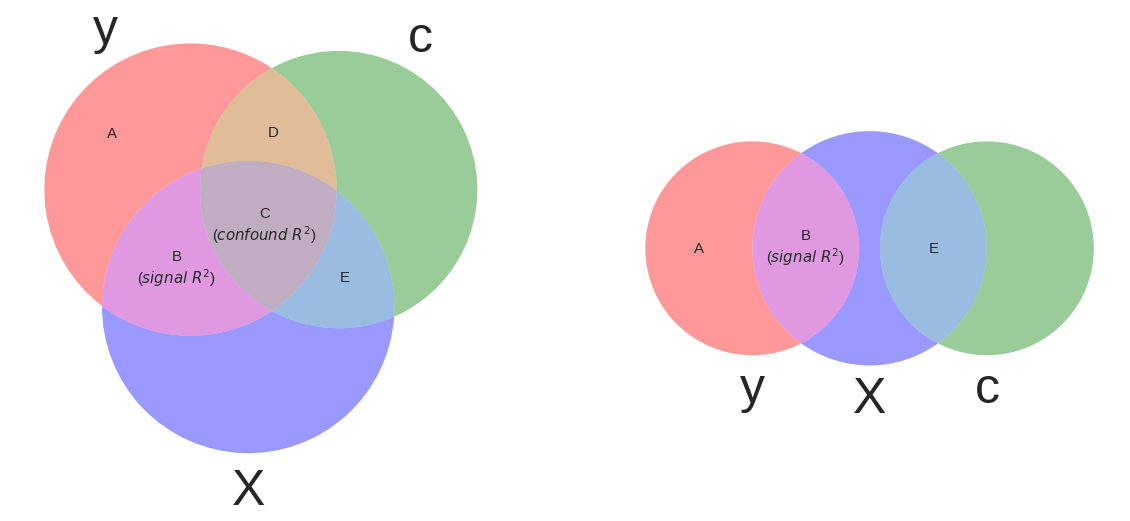

In [62]:
mappings = {'100': 'A', '110': 'D', '010': '',
            '101': "B\n($signal\ R^2$)", '111': 'C\n($confound\ R^2$)', '011': 'E',
            '001': ''}

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
v = venn3(subsets=(1, 1, 0.1, 1, 0.3, 0.1, 0.6), set_labels=('y', 'c', 'X'))

for key, value in mappings.items():
    v.get_label_by_id(key).set_text(value)
    v.get_label_by_id(key).set_size(15)
    
for label in ['A', 'B', 'C']:
    v.get_label_by_id(label).set_size(50)

plt.subplot(1, 2, 2)    
v = venn3(subsets=(1.5, 1.5, 0.0, 1, 1, 1, 0.0), set_labels=('y', 'c', 'X'))

for key, value in mappings.items():
    if key in ['111', '110']:
        continue
    v.get_label_by_id(key).set_text(value)
    v.get_label_by_id(key).set_size(15)
    
for label in ['A', 'B', 'C']:
    v.get_label_by_id(label).set_size(50)

plt.show()

So, what must happen is that component **B** (right diagram) must increase with increasing $\rho(cy)$.

## Scenario 3: what happens when we vary $\rho(y.X\ |\ c)$?
... or, in other words, what happens in we increase the true (unconfounded) signal?

### Confound = categorical

In [72]:
permutations = 1

data_args = dict(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.65,
                 signal_r2=None, confound_r2=None, verbose=False)
    
signal_r2_vec = [0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
confound_r2_vec = [0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
baseline_scores = np.zeros((permutations, len(signal_r2_vec)))

results = []
results_corr = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))

    for i, signal_r2 in enumerate(signal_r2_vec):
        data_args.update(confound_r2=None)
        data_args.update(signal_r2=signal_r2)
        base_args = deepcopy(data_args)
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for ii, confound_r2 in enumerate(confound_r2_vec):
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            res, corrs = run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args, c_type='categorical',
                                                   metric='corr', threshold=0.01)
            results_corr.append(corrs)
            results.append(res)

Permutation: 1


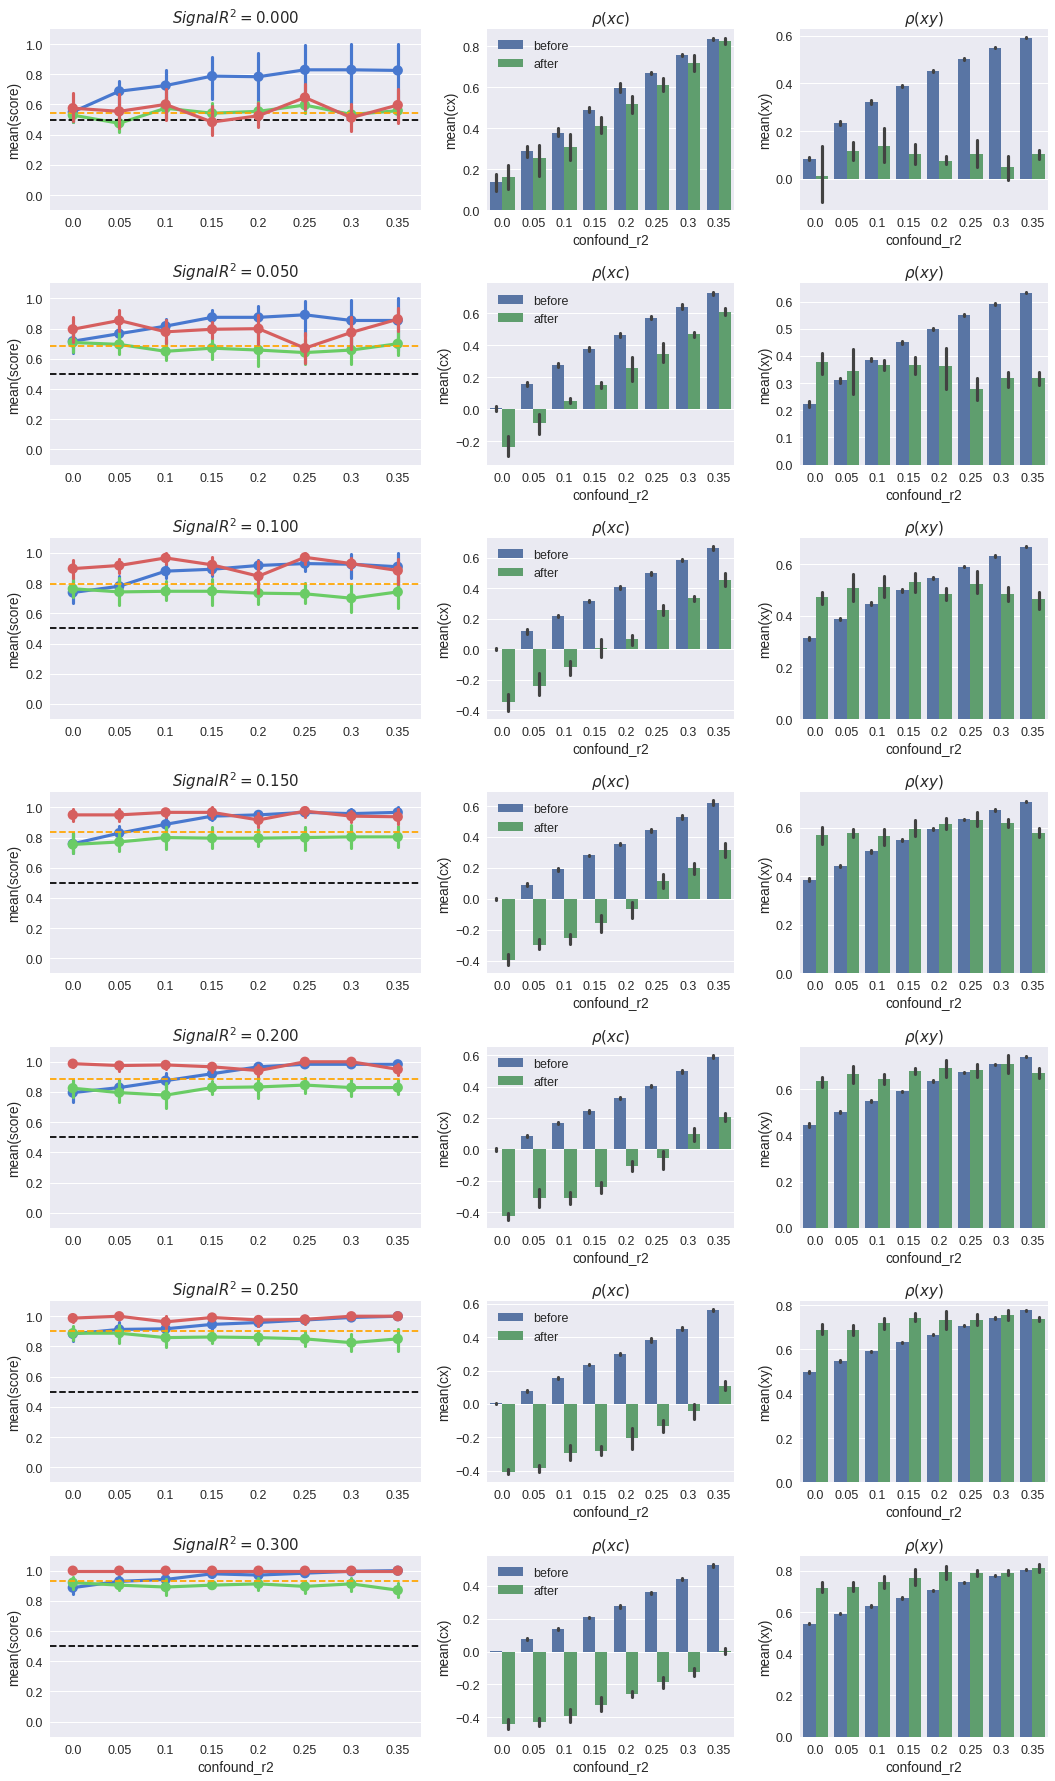

In [73]:
sns.set(font_scale=1.25)
df = pd.concat(results)
df_corrs = pd.concat(results_corr)
fig, axes = plt.subplots(len(signal_r2_vec), 3, figsize=(15, 25), gridspec_kw={'width_ratios': [1.5, 1, 1]})

for i in range(len(axes)):
    tmp = df[df.signal_r2 == signal_r2_vec[i]]
    axes[i][0].set_title("$Signal R^2 = %.3f$" % signal_r2_vec[i])
    g = sns.pointplot(x='confound_r2', y='score', hue='method',
                      data=tmp, size=5, aspect=2,
                      palette="muted", ax=axes[i][0])
    g.legend_.remove()
    
    if i != len(axes) - 1:
        axes[i][0].set_xlabel('')
    
    g.set_ylim((-0.1, 1.1))
    axes[i][0].axhline(y=0.5, c='black', ls='--')
    axes[i][0].axhline(y=baseline_scores[:, i].mean(axis=0), c='orange', ls='--')

    tmp = df_corrs[df_corrs.signal_r2 == signal_r2_vec[i]]
    axes[i][1].set_title(r'$\rho(xc)$')
    g = sns.barplot(x="confound_r2", y="cx", hue="before_after", data=tmp, ax=axes[i][1])
    g.legend_.remove()
    axes[i][1].legend(loc='best')
    axes[i][2].set_title(r'$\rho(xy)$')
    g = sns.barplot(x="confound_r2", y="xy", hue="before_after", data=tmp, ax=axes[i][2])
    g.legend_.remove()

fig.tight_layout()

Same plot, but x-axis and factor (signal r2) reversed:

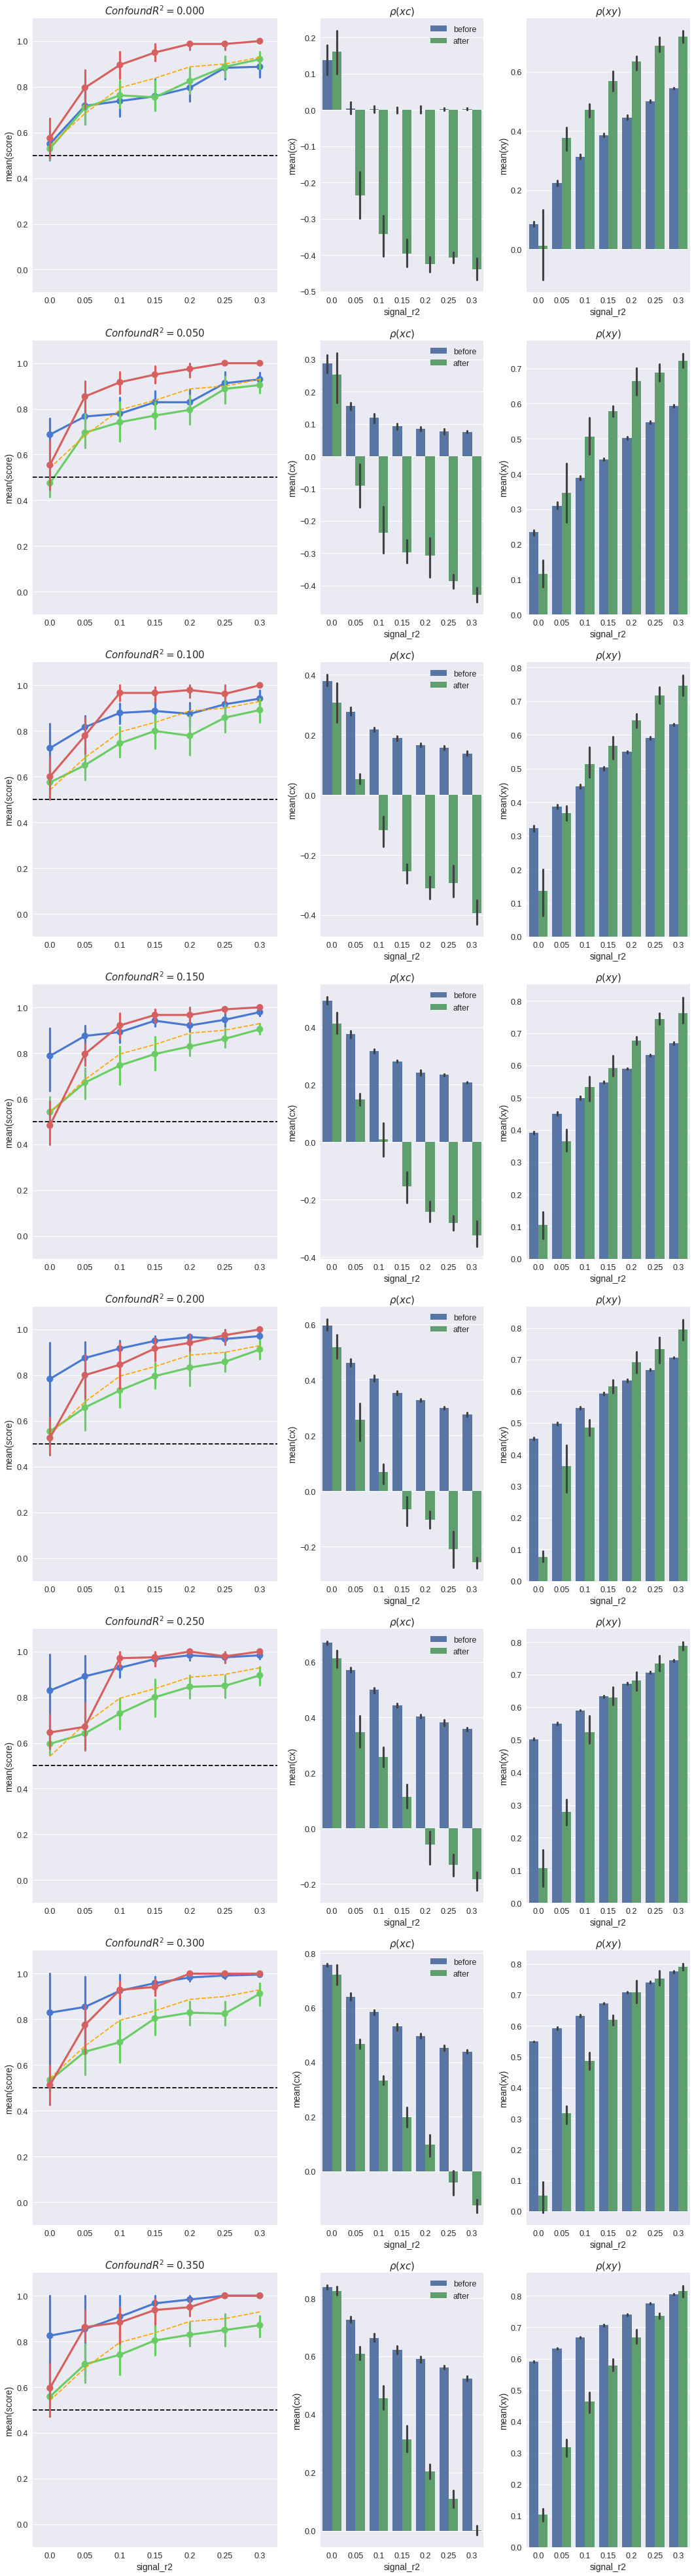

In [74]:
sns.set(font_scale=1.25)
df = pd.concat(results)
df_corrs = pd.concat(results_corr)
fig, axes = plt.subplots(len(confound_r2_vec), 3, figsize=(15, 55), gridspec_kw={'width_ratios': [1.5, 1, 1]})

for i in range(len(axes)):
    tmp = df[df.confound_r2 == confound_r2_vec[i]]
    axes[i][0].set_title("$Confound R^2 = %.3f$" % confound_r2_vec[i])
    g = sns.pointplot(x='signal_r2', y='score', hue='method',
                      data=tmp, size=5, aspect=2,
                      palette="muted", ax=axes[i][0])
    g.legend_.remove()
      
    axes[i][0].plot(np.arange(len(signal_r2_vec)), baseline_scores.mean(axis=0), color='orange', ls='--')
    
    if i != len(axes) - 1:
        axes[i][0].set_xlabel('')
    
    g.set_ylim((-0.1, 1.1))
    axes[i][0].axhline(y=0.5, c='black', ls='--')
    # axes[i][0].plot(x=np.arange(6), y=baseline_scores.mean(axis=0), c='orange', ls='--')

    tmp = df_corrs[df_corrs.confound_r2 == confound_r2_vec[i]]
    axes[i][1].set_title(r'$\rho(xc)$')
    g = sns.barplot(x="signal_r2", y="cx", hue="before_after", data=tmp, ax=axes[i][1])
    g.legend_.remove()
    axes[i][1].legend(loc='best')
    axes[i][2].set_title(r'$\rho(xy)$')
    g = sns.barplot(x="signal_r2", y="xy", hue="before_after", data=tmp, ax=axes[i][2])
    g.legend_.remove()

fig.tight_layout()

### Confound = continuous

In [ ]:
permutations = 1

data_args = dict(n_samp=240, k_feat=5, c_type='continuous', corr_cy=0.8,
                 signal_r2=None, confound_r2=None, verbose=False)
    
signal_r2_vec = [0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
confound_r2_vec = [0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
baseline_scores = np.zeros((permutations, len(signal_r2_vec)))

results = []
results_corr = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))

    for i, signal_r2 in enumerate(signal_r2_vec):
        print('Signal r2: %.3f' % signal_r2)
        data_args.update(signal_r2=signal_r2)
        base_args = deepcopy(data_args)
        base_args['c_type'] = 'none'
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for ii, confound_r2 in enumerate(confound_r2_vec):
            print('Confound r2: %.3f' % confound_r2)
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            res, corrs = run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args, c_type='continuous',
                                                   metric='corr', threshold=0.01)
            results_corr.append(corrs)
            results.append(res)

### EVERYTHING BELOW IS IRRELEVANT FOR NOW (LUKAS' PLAYGROUND)

In [ ]:
K_FEAT = 5
data_args = dict(n_samp=240, k_feat=K_FEAT, c_type='categorical', corr_cy=0.7,
                 signal_r2=0.1, confound_r2=0.49, verbose=False)
X, y, c = generate_data(**data_args)

corrs_xc_before = [pearsonr(c, X[:, i])[0] for i in range(X.shape[1])]
corrs_xy_before = [pearsonr(y, X[:, i])[0] for i in range(X.shape[1])]

skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=10, c_type='categorical', verbose=False)
skf.check_counterbalance_and_subsample()
X, y, c = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    
corrs_xc_after = np.array([pearsonr(c, X[:, i])[0] for i in range(X.shape[1])])
corrs_xy_after = np.array([pearsonr(y, X[:, i])[0] for i in range(X.shape[1])])

scores = np.zeros(n_splits)
corrs_xy_train = np.zeros((10, K_FEAT))
corrs_xy_test = np.zeros((10, K_FEAT))

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train, c_train = X[train_idx], y[train_idx], c[train_idx]
    X_test, y_test, c_test = X[test_idx], y[test_idx], c[test_idx]
    
    corrs_xy_train[i, :] = np.array([pearsonr(y_train, X_train[:, i])[0] for i in range(X.shape[1])])
    corrs_xy_test[i, :] = np.array([pearsonr(y_test, X_test[:, i])[0] for i in range(X.shape[1])])
    pipeline.fit(X_train, y_train)
    
    scores[i] = pipeline.score(X_test, y_test)
print(scores.mean())

## Scenario 4: what happens if we vary the number of samples? 

### Confound = categorical

In [ ]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=None, k_feat=5, c_type='categorical', corr_cy=None,
                 signal_r2=0.1, confound_r2=0.1, verbose=False)

n_samples_vec = [20, 50, 100, 200, 500, 1000]

baseline_scores = np.zeros((permutations, len(n_samples_vec)))

results = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))
    
    Xbase, ybase = generate_data(**base_args) 
    baseline_scores[perm] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()

    for i, n_samp in enumerate(n_samples_vec):
        data_args.update(n_samp=n_samp)
        
        base_args = deepcopy(data_args)
        base_args['c_type'] = 'none'
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for corr_cy in [0.4, 0.5, 0.6, 0.7]:
            data_args.update(corr_cy=corr_cy)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))
            
sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='n_samp', y='score', hue='method', col='corr_cy', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g = g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('N samples', 'Score')

for ax in g.axes:
    ax.plot(np.arange(len(n_samples_vec)), baseline_scores.mean(axis=0), color='red', ls='--')

### Confound = continuous

In [ ]:
n_splits = 10
permutations = 2

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=None, k_feat=5, c_type='continuous', corr_cy=None,
                 signal_r2=0.1, confound_r2=0.1, verbose=False)

n_samples_vec = [20, 50, 100, 200, 500, 1000]

baseline_scores = np.zeros((permutations, len(n_samples_vec)))

results = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))
    
    for i, n_samp in enumerate(n_samples_vec):
        data_args.update(n_samp=n_samp)
        
        base_args = deepcopy(data_args)
        base_args['c_type'] = 'none'
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for corr_cy in [0.4, 0.5, 0.6, 0.7]:
            data_args.update(corr_cy=corr_cy)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args,
                                                     c_type='continuous', metric='corr', threshold=0.01))
            
sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='n_samp', y='score', hue='method', col='corr_cy', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g = g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('N samples', 'Score')
for ax in g.axes:
    ax.plot(np.arange(len(n_samples_vec)), baseline_scores.mean(axis=0), color='red', ls='--')

## Scenario 5: what happens when we vary the number of features?
We also vary the strength of the confound signal in X (confound_r2).

### Confound = categorical

In [ ]:
n_splits = 10
permutations = 1

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=240, k_feat=None, c_type='categorical', corr_cy=0.7,
                 signal_r2=0.1, confound_r2=None, verbose=False)

k_feat_vec = [1, 5, 10, 20, 50, 100, 500, 1000, 10000]

baseline_scores = np.zeros((permutations, len(k_feat_vec)))

results = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))
    
    for i, k_feat in enumerate(k_feat_vec):
        data_args.update(k_feat=k_feat)
        print("k feat: %i" % k_feat)
        base_args = deepcopy(data_args)
        base_args['c_type'] = 'none'
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for confound_r2 in [0, 0.1, 0.2, 0.3, 0.4]:
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args,
                                                     c_type='categorical'))

sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='k_feat', y='score', hue='method', col='confound_r2', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g = g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('K features', 'Score')

for ax in g.axes:
    ax.plot(np.arange(len(k_feat_vec)), baseline_scores.mean(axis=0), color='red', ls='--')

### Confound = continuous

In [ ]:
n_splits = 10
permutations = 1

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=240, k_feat=None, c_type='continuous', corr_cy=0.7,
                 signal_r2=0.1, confound_r2=None, verbose=False)

k_feat_vec = [1, 5, 10, 20, 50, 100, 500, 1000, 10000]

baseline_scores = np.zeros((permfor ax in g.axes:
    ax.plot(np.arange(len(k_feat_vec)), baseline_scores.mean(axis=0), color='red', ls='--')utations, len(k_feat_vec)))

results = []
for perm in np.arange(permutations):

    print("Permutation: %i" % (perm + 1))
    
    for i, k_feat in enumerate(k_feat_vec):
        data_args.update(k_feat=k_feat)
        print("k feat: %i" % k_feat)
        base_args = deepcopy(data_args)
        base_args['c_type'] = 'none'
        Xbase, ybase = generate_data(**base_args) 
        baseline_scores[perm, i] = cross_val_score(pipeline, Xbase, ybase, cv=n_splits).mean()
        
        for confound_r2 in [0, 0.1, 0.2, 0.3, 0.4]:
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args,
                                                     c_type='continuous', metric='corr', threshold=0.01))


sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='k_feat', y='score', hue='method', col='confound_r2', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g = g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('K features', 'Score')
for ax in g.axes:
    ax.plot(np.arange(len(k_feat_vec)), baseline_scores.mean(axis=0), color='red', ls='--')

## Messing around

In [ ]:
n_splits = 10
X, y, c = generate_data(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.6,
                        signal_r2=0.1, confound_r2=0.2, verbose=False)

skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=n_splits, c_type='categorical', verbose=True)
skf.check_counterbalance_and_subsample()

X, y, c = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    

scores = np.zeros(n_splits)
y_c_r2 = np.zeros(n_splits)
y_xc_r2 = np.zeros((n_splits, X.shape[1]))
y_x_r2 = np.zeros((n_splits, X.shape[1]))
unique_var_x = np.zeros((n_splits, X.shape[1]))
unique_var_c = np.zeros((n_splits, X.shape[1]))
shared_var_xc = np.zeros((n_splits, X.shape[1]))
d = np.zeros((n_splits, X.shape[1]))

this_pipe = pipeline

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    c_train = c[train_idx][:, np.newaxis]
    y_c_r2[i] = get_r2(c_train, y_train)
    
    for ii in range(X_train.shape[1]):
        y_xc_r2[i, ii] = get_r2(np.hstack((X_train[:, ii][:, np.newaxis], c_train)), y_train)
        y_x_r2[i, ii] = get_r2(X_train[:, ii], y_train)
        
        resid_y = 1 - y_xc_r2[i, ii]  # A = 1 - (B + C + D)
        unique_var_x[i, ii] = y_xc_r2[i, ii] - y_c_r2[i]  # B
        unique_var_c[i, ii] = y_xc_r2[i, ii] - y_x_r2[i, ii]  # D
        shared_var_xc[i, ii] = 1 - resid_y - unique_var_x[i, ii] - unique_var_c[i, ii]  # C = 
        d[i, ii] = y_c_r2[i] - shared_var_xc[i, ii]
    
    print("TRAIN")
    print("R2(y_xc)): %r" % np.round(y_xc_r2.mean(axis=0), 4).tolist())
    print("R2(y_x): %r" % np.round(y_x_r2.mean(axis=0), 4).tolist())
    print("R2(signal): %r" % np.round(unique_var_x.mean(axis=0), 4).tolist())
    print("R2(confound): %r" % np.round(shared_var_xc.mean(axis=0), 4).tolist())
    print("R2(D): %r" % np.round(d.mean(axis=0), 4).tolist())
    
    print('')

    c_test = c[test_idx][:, np.newaxis]
    for ii in range(X_test.shape[1]):
        y_xc_r2[i, ii] = get_r2(np.hstack((X_test[:, ii][:, np.newaxis], c_test)), y_test)
        y_x_r2[i, ii] = get_r2(X_test[:, ii], y_test)
        
        resid_y = 1 - y_xc_r2[i, ii]  # A = 1 - (B + C + D)
        unique_var_x[i, ii] = y_xc_r2[i, ii] - y_c_r2[i]  # B
        unique_var_c[i, ii] = y_xc_r2[i, ii] - y_x_r2[i, ii]  # D
        shared_var_xc[i, ii] = 1 - resid_y - unique_var_x[i, ii] - unique_var_c[i, ii]  # C = 
        d[i, ii] = y_c_r2[i] - shared_var_xc[i, ii]
    
    print("TEST")
    print("R2(y_xc)): %r" % np.round(y_xc_r2.mean(axis=0), 4).tolist())
    print("R2(y_x): %r" % np.round(y_x_r2.mean(axis=0), 4).tolist())
    print("R2(signal): %r" % np.round(unique_var_x.mean(axis=0), 4).tolist())
    print("R2(confound): %r" % np.round(shared_var_xc.mean(axis=0), 4).tolist())
    print("R2(D): %r" % np.round(d.mean(axis=0), 4).tolist())
    
    print('')

    
    this_pipe.fit(X_train, y_train)
    scores[i] = this_pipe.score(X_test, y_test)
print(scores.mean())

In [ ]:
n_splits = 10
X, y, c = generate_data(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.4,
                        signal_r2=0.1, confound_r2=0.1, verbose=False)

scores = np.zeros(n_splits)
y_c_r2 = np.zeros(n_splits)
y_xc_r2 = np.zeros((n_splits, X.shape[1]))
y_x_r2 = np.zeros((n_splits, X.shape[1]))
unique_var_x = np.zeros((n_splits, X.shape[1]))
unique_var_c = np.zeros((n_splits, X.shape[1]))
shared_var_xc = np.zeros((n_splits, X.shape[1]))

skf = StratifiedKFold(n_splits=n_splits)
this_pipe = Pipeline(pipeline)
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    cr = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    c_train = c[train_idx][:, np.newaxis]
    y_c_r2[i] = get_r2(c_train, y_train)

    X_train = cr.fit_transform(X_train)
    X_test = cr.transform(X_test)
    
    for ii in range(X_train.shape[1]):
        y_xc_r2[i, ii] = get_r2(np.hstack((X_train[:, ii][:, np.newaxis], c_train)), y_train)
        y_x_r2[i, ii] = get_r2(X_train[:, ii], y_train)
        
        resid_y = 1 - y_xc_r2[i, ii]  # A = 1 - (B + C + D)
        unique_var_x[i, ii] = y_xc_r2[i, ii] - y_c_r2[i]  # B
        unique_var_c[i, ii] = y_xc_r2[i, ii] - y_x_r2[i, ii]  # D
        shared_var_xc[i, ii] = 1 - resid_y - unique_var_x[i, ii] - unique_var_c[i, ii]  # C = 
    
    print("R2(y_xc)): %r" % np.round(y_xc_r2.mean(axis=0), 4).tolist())
    print("R2(y_x): %r" % np.round(y_x_r2.mean(axis=0), 4).tolist())
    print("R2(signal): %r" % np.round(unique_var_x.mean(axis=0), 4).tolist())
    print("R2(confound): %r" % np.round(shared_var_xc.mean(axis=0), 4).tolist())
    
    print('')
    
    this_pipe.fit(X_train, y_train)
    scores[i] = this_pipe.score(X_test, y_test)
print(scores.mean())

### An old version of the data generation algorithm
Didn't really work.

In [7]:
def generate_data_from_dist(n_samp, k_feat, c_type, corr_cy, signal_r2, confound_r2=None, verbose=False, plot=False):
    """ Similar to above, but draw generative parameters from distribution. """
    
    if n_samp % 2 != 0:
        raise ValueError("Please select an even number of samples "
                         "(Makes things easier.)")

    if confound_r2 is not None:
        if np.abs(corr_cy) < np.sqrt(confound_r2):
            raise ValueError("The desired corr_cy value is less than the square "
                             "root of the desired confound R-squared ... This is "
                             "impossible to generate.")
        
    # Generate y (balanced, 50% class 0, 50% class 1)
    y = np.repeat([0, 1], repeats=n_samp / 2)
    
    # Generate c (confound), with given correlation corr_cy
    if c_type == 'categorical':
        # Simply shift ("roll") y to create correlation using the "formula":
        # to-shift = N / 4 * (1 - corr_cy)
        to_roll = int((n_samp / 4) * (1 - corr_cy))
        c = np.roll(y, to_roll)
    elif c_type == 'continuous':
        # If c is continuous, just sample y + random noise
        noise_factor = 100
        c = y + np.random.randn(n_samp) * noise_factor
        corr = pearsonr(c, y)[0]
        
        while np.abs(corr - corr_cy) > 0.01:
            # Decrease noise if the difference is too big
            noise_factor -= 0.01
            c = y + np.random.randn(n_samp) * noise_factor
            corr = pearsonr(c, y)[0]        
    else:
        raise ValueError("For c_type, please select from {'continuous', "
                         "'categorical'}")

    noise_factor = 0.1

    while True:
        
        gen_y_mean = np.random.normal(0, 1, size=1)
        gen_c_mean = np.random.normal(0, 1, size=1)
        gen_y_std = 0.5#np.abs(np.random.normal(0.0, 0.1, size=1))
        gen_c_std = 0.5#np.abs(np.random.normal(0.0, 0.1, size=1))
        
        should_continue = False
        gen_beta_y = np.random.normal(gen_y_mean, gen_y_std, size=(n_samp, k_feat))
        gen_beta_c = np.random.normal(gen_c_mean, gen_c_std, size=(n_samp, k_feat))

        X = (gen_beta_y * y[:, np.newaxis] + 
             gen_beta_c * c[:, np.newaxis] + 
             np.random.randn(n_samp, k_feat) * noise_factor)
        
        y_x_r2 = np.array([get_r2(iv=X[:, i, np.newaxis], dv=y) for i in range(k_feat)])  # B + C
        
        if confound_r2 is None:
            # We don't care about confound_r2
            unique_var_x = y_x_r2
        else:
            # Fit y = b1X + b2C
            y_xc_r2 = np.array([get_r2(iv=np.hstack((X[:, i, np.newaxis], c[:, np.newaxis])), dv=y)
                                for i in range(k_feat)])  # B + C + D
            resid_y = 1 - y_xc_r2  # A = 1 - (B + C + D)

            # Fit y = b1C
            y_c_r2 = get_r2(iv=c, dv=y)  # C + D
            unique_var_x = y_xc_r2 - y_c_r2  # B

        # Increase/decrease generative param for y if difference 
        # r(yx.c) is too small/big ...
        difference_obs_vs_desired = unique_var_x.mean() - signal_r2
        if np.abs(difference_obs_vs_desired) > 0.01:
            if difference_obs_vs_desired < 0:
                gen_y_mean += 0.01
            else:
                gen_y_mean -= 0.01

            if confound_r2 is None:
                continue
            else:
                should_continue = True
        else:
            if confound_r2 is None:
                break
  
        unique_var_c = y_xc_r2 - y_x_r2  # D
        shared_var_xc = 1 - resid_y - unique_var_x - unique_var_c  # C

        # Also check if shared variance of c and x (component C) is appropriate;
        # if not, adjust generative parameter and CONTINUE
        difference_obs_vs_desired = shared_var_xc.mean() - confound_r2
        if np.abs(difference_obs_vs_desired) > 0.01:
            if difference_obs_vs_desired < 0:
                gen_c_mean += 0.05
            else:
                gen_c_mean -= 0.05
            should_continue = True

        if should_continue:
            
            if verbose:
                print("Total r2: %.3f" % y_x_r2.mean())
                print("Confound r2: %.3f" % shared_var_xc.mean())
                print("Signal r2: %.3f" % unique_var_x.mean())
                print("gen_y_mean: %.2f" % gen_y_mean)
                print("gen_c_mean: %.2f" % gen_c_mean, end='\n\n')
            continue

        # If we didn't encounter a "break" statement, we must have found
        # data with the correct specifications ...
        signal_r2_values = unique_var_x
        if confound_r2 is not None:
            confound_r2_values = shared_var_xc
        break

    if verbose:
        print("Signal r2: %.3f" % signal_r2_values.mean())
        
        if confound_r2 is not None:
            print("Confound r2: %.3f" % confound_r2_values.mean())
        
        print("Final gen_y_mean: %.3f" % gen_y_mean)
        print("Final gen_c_mean: %.3f" % gen_c_mean)
    
    if plot:
        kinds = ['signal_r2'] * k_feat + ['confound_r2'] * k_feat
        df = dict(corrs=np.hstack((signal_r2_values, confound_r2_values)), kind=kinds)
        g = sns.FacetGrid(pd.DataFrame(df), col="kind", margin_titles=True)
        g.map(plt.hist, "corrs", color="steelblue")
        
    if confound_r2 is None:
        return X, y
    else:
        return X, y, c